In [1]:
#### ---- Self-adaptive weighted filter to remove GAUSSIAN & IMPULSIVE noise in INFRARED images ---- ####

## TODO: 

##########################################################################################################

# -> check which pixel is noise point:
####   -> 3x3 filter window
####   -> d[8] = differences between center pixel and neighbors in the 3x3 window
####   -> thresholds T1(difference), T2(number of pixels) and N(nr of neighbors where d[i]>T1):
######       -> N=0 => Gaussian noise (no pixels with big difference)
######       -> N>T2 => Impulsive noise (more pixels with big difference)
######       -> 0<N<T2 => detail point, stays the same
######       -> good values for T1 and T2 (based on image details, maybe histogram)
########            -> T1 - [40,90]
########            -> T2 - [1,7]
########            -> the more the image details, the bigger T1/T2  

# -> Gauusian noise pixel => self adaptive weighted MEAN filter
####   -> calculate average
####   -> calculate weights based on diff between pixel value and avg
####   -> normalize
####   -> replace central pixel with img[i,j] x w[x,y] 

# -> Impulsive noise pixel => Self adaptive weighted MEDIAN filter
####   -> sort pixels from 3x3 window in a vector
####   -> get rid of 1st and last value
####   -> see middle value = middle_val
####   -> calculate weights based on diff between pixel and middle_val
####   -> normalize
####   -> replace central pixel with img[i,j] x w[x,y]

##########################################################################################################

# Functions:
#   -> calculate_weights:
#   -> self_adaptive_gaussian_filter
#   -> self_adaptive_impusive_filter
#   -> compute_image_based_on_noise

##########################################################################################################

In [36]:
import numpy as np
import cv2
from scipy import signal
from skimage import io, color
from matplotlib import pyplot as plt

window_size = 3
W = window_size//2
poz_median=window_size*window_size//2

In [39]:
def add_gaussian_noise(img,disp):
    # parametrii : imaginea originala, dispersia zgomotului
    h,w = np.shape(img)
    noise = np.random.normal(0,disp,(h,w))
    img_noise = img + noise
    # intoarce imaginea cu zgomot
    return img_noise

In [15]:
def bordare_imagine(image, window_size = 3):
    
    [L,C]=np.shape(image)
    kernel=np.zeros((window_size,window_size))
    kernel[W,W]=1
    Ybordat=np.zeros((L+window_size-1,C+window_size-1))
    Ybordat[:,:] = signal.convolve2d(image[:,:], kernel, mode='full', boundary='symm')

    return Ybordat

In [33]:
def calculate_weights(flattened_window, diff):
    """Calculate adaptive weights for a filter window."""

    differences = np.abs(flattened_window - diff)
    weights = 1/(1+differences**2)
    normalized_weights = weights/np.sum(weights)

    return normalized_weights

flattened_window = np.array([8, 2, 10, 4, 6, 9])
diff = 7

print(calculate_weights(flattened_window, diff))


[0.34759358 0.02673797 0.06951872 0.06951872 0.34759358 0.13903743]


In [16]:
# def self_adaptive_weighted_mean_filter(image, window_size=3):
#     """Apply the self-adaptive weighted mean filter."""
#     pad = window_size // 2
#     padded_image = np.pad(image, pad, mode='reflect')
#     output = np.zeros_like(image)

#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             # Extract local window
#             window = padded_image[i:i + window_size, j:j + window_size]
#             mean = np.mean(window)
#             weights = calculate_weights(window, mean)
#             output[i, j] = np.sum(window * weights)

#     return output


def self_adaptive_gaussian_filter(img, window_size):
    """Apply the self-adaptive weighted mean filter for every channel, RGB."""

    if (np.max(img)>1):
        img = img/255.0
    [L,C]=np.shape(img)

    Ybordat = bordare_imagine(img, window_size)

    imgout = np.zeros((L,C))
    for l in range(0,L):
        for c in range(0,C):
            # selecteaza valori conform ferestrei plasate in pozitia (l,c)
            val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W] # shiftez cu W

            # calculare medie si weights
            mean = np.mean(val_selectate)
            weights = calculate_weights(val_selectate, mean)
            
            # scrie rezultatul in imgout[l,c]
            imgout[l,c] = np.sum(weights*val_selectate[:,:])

    return imgout


In [17]:
# def self_adaptive_weighted_median_filter(image, window_size=3):
#     """Apply the self-adaptive weighted median filter."""
#     pad = window_size // 2
#     padded_image = np.pad(image, pad, mode='reflect')
#     output = np.zeros_like(image)

#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             # Extract local window
#             window = padded_image[i:i + window_size, j:j + window_size].flatten()
#             median = np.median(window)
#             weights = calculate_weights(window, median)
#             weighted_values = window * weights
#             output[i, j] = np.sum(weighted_values) / weights.sum()

#     return output



def self_adaptive_impusive_filter(image, window_size = 3):
    """Apply the self-adaptive weighted median filter."""
    if (np.max(img)>1):
        img = img/255.0
    [L,C]=np.shape(img)

    Ybordat = bordare_imagine(img, window_size)

    imgout = np.zeros((L,C))
    for l in range(0,L):
        for c in range(0,C):
            # selecteaza valori conform ferestrei plasate in pozitia (l,c)
            val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W] # shiftez cu W

            # sortam valorile, eliminam prima si ultima valoare & calculam weights
            val_sortate = np.sort(val_selectate)
            val_sortate = val_sortate[1:np.size(val_sortate)-1]
            middle_val = val_sortate[np.size(val_sortate)//2+1]
            weights = calculate_weights(val_sortate, middle_val)
            
            # scrie rezultatul in imgout[l,c]
            imgout[l,c] = np.sum(weights*val_selectate[:,:])

    return imgout

    

In [7]:
def gaussian_filter_only_in_window(window):
    # 3x3 window
    mean = np.mean(window)
    weights = calculate_weights(window, mean)

    centered_pixel = np.zeros((3))
    for plan in range(0,3):
        centered_pixel[plan] = np.sum(weights*window[:,:,plan])  

    return centered_pixel  

def impulsive_filter_only_in_window(window):
    # 3x3 window
    val_sortate = np.sort(window)
    val_sortate = val_sortate[1:np.size(val_sortate)-1]
    middle_val = val_sortate[np.size(val_sortate)//2+1]
    weights = calculate_weights(val_sortate, middle_val)
    

    centered_pixel = np.zeros((3))
    for plan in range(0,3):
        centered_pixel[plan] = np.sum(weights*window[:,:,plan])  

    return centered_pixel

In [8]:
def classify_noise(image, T1=40, T2=5, window_size=3):
    """Classify noise types and apply appropriate filter."""
    pad = window_size // 2
    padded_image = np.pad(image, pad, mode='reflect')
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract local window
            window = padded_image[i:i + window_size, j:j + window_size].flatten()
            center_value = padded_image[i + pad, j + pad]
            differences = np.abs(window - center_value)
            num_high_differences = np.sum(differences > T1)

            if num_high_differences == 0:
                # Gaussian noise
                mean = np.mean(window)
                weights = calculate_weights(window, mean)
                output[i, j] = np.sum(window * weights)
            elif num_high_differences > T2:
                # Impulse noise
                median = np.median(window)
                weights = calculate_weights(window, median)
                output[i, j] = np.sum(window * weights)
            else:
                # Detail points
                output[i, j] = center_value

    return output

T1 = 50
T2 = 4

def compute_image_based_on_noise(img, T1, T2):
    """Classify noise types and apply appropriate filter."""
    if (np.max(img)>1):
        img = img/255.0
    [L,C,pl]=np.shape(img)

    Ybordat = bordare_imagine(img, window_size)

    imgout = np.zeros((L,C,pl))

    for l in range(0,L):
        for c in range(0,C):
            # selecteaza valori conform ferestrei plasate in pozitia (l,c)
            val_selectate = Ybordat[l-W+W:l+W+1+W,c-W+W:c+W+1+W,:] # shiftez cu W
            val_selectate_R = val_selectate[:,:,0].flatten()
            val_selectate_G = val_selectate[:,:,1].flatten()
            val_selectate_B = val_selectate[:,:,2].flatten()

            # continuam in alta zi
            # TODO: incearca sa faci functie pt fiecare plan de culoare ca sa nu repeti mult cod
            # (sau intai faci pt grayscale si apoi extinzi)

    
    return imgout


(513, 768)


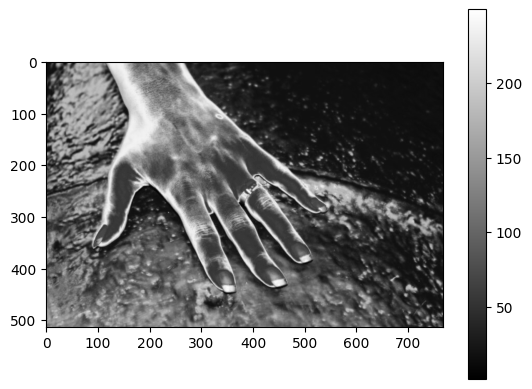

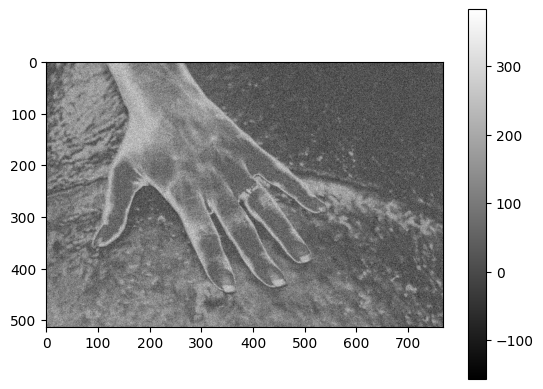

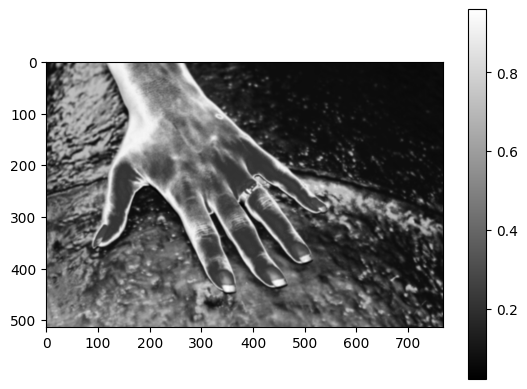

(<Figure size 640x480 with 2 Axes>,
 None)

In [45]:
# Example usage

# Load grayscale image
# img = cv2.imread('infrared-768x513.jpg', cv2.IMREAD_GRAYSCALE)
img = io.imread('infrared-768x513.jpg')
img=np.uint8(color.rgb2gray(img)*255)
print(np.shape(img))
plt.figure(), plt.imshow(img, cmap='gray'),plt.colorbar(),plt.show()

# add gaussian noise
img_noise = add_gaussian_noise(img, 40)
plt.figure(), plt.imshow(img_noise, cmap='gray'),plt.colorbar(),plt.show()

# Apply the self-adaptive weighted filter
filtered_image = self_adaptive_gaussian_filter(img, 3)

# Save or display the result
# cv2.imwrite('filtered_image.png', filtered_image)
# cv2.imshow('Filtered Image', filtered_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.figure(), plt.imshow(filtered_image, cmap='gray'),plt.colorbar(),plt.show()


In [ ]:
# TODO remaining
# Make functions for grayscale images (almost done)
# Make functions for color images (grascale functions applied for RGB)
# See results
# Refine code